In [1]:
# ! pip install matplotlib seaborn numpy pandas  

In [2]:
import pandas as pd
from datetime import datetime, timedelta
import time
import requests  
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, to_rgba
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.dates import DateFormatter
from matplotlib.ticker import FuncFormatter
import numpy as np
from scipy.interpolate import UnivariateSpline
import os
import subprocess
from rich.jupyter import print
from rich.prompt import Prompt
from constants import OUTDATA_DIR

REQUEST_COLOR = "#8E6A1A"
CONCURRENCY_COLOR = "#37795D"
BG_COLOR = "#F5EFF9"
LABELPAD=8

custom_params = {
    "axes.spines.left": False, 
    "axes.spines.right": False, 
    "axes.spines.top": False,
    "axes.spines.bottom": False,
    "axes.grid": False,
    "axes.facecolor": BG_COLOR,
    "figure.facecolor": BG_COLOR
}
sns.set_theme(rc=custom_params)
pd.options.mode.copy_on_write = True

In [3]:
def create_mapping_function(a, b, _max = 250, _min = 10):
    def mapping_function(x):
        if x < a or x > b:
            raise ValueError(f"The input number {x} is out of the range [{a}, {b}]")
        return _min + (x - a) * (_max - _min) / (b - a)
    return mapping_function

def create_alpha_colormap(hex_color, alpha_bottom, alpha_top):
    rgb_color = to_rgba(hex_color)[:3] 
    return LinearSegmentedColormap.from_list(
        'alpha_colormap',
        [(rgb_color[0], rgb_color[1], rgb_color[2], alpha_bottom),
         (rgb_color[0], rgb_color[1], rgb_color[2], alpha_top)]
    )

def format_func(value, tick_number):
    dt = datetime.fromtimestamp(value)
    return dt.strftime('%H:%M:%S')

In [4]:
default_path_candidates = os.listdir(OUTDATA_DIR)
default_path = [os.path.join(OUTDATA_DIR, p) for p in default_path_candidates if p.endswith('_results.csv')][0]
# data_path = Prompt.ask("Which data are you analyzing?", default=default_path)
data_path=default_path

In [5]:
df = pd.read_csv(data_path)
df = df[df.prompt_tokens>45589] # some tiny experiments in the raw data.
df['total_tokens'] = df.prompt_tokens + df.completion_tokens
def f(ts):
    return datetime.fromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')
df.start_ts = df.start_ts.apply(f)
df.end_ts = df.end_ts.apply(f)
df

,prompt_tokens,completion_tokens,total_requests,total_time,concurrent_requests,n_requests_per_thread,max_tokens_per_request,start_ts,end_ts,device,total_tokens
0,293868,9970,100,180.794247,1,100,100,2024-06-08 19:41:39,2024-06-08 19:44:39,nvidia_a100-pcie-40gb,303838
1,303743,33156,100,542.616125,1,100,500,2024-06-08 19:44:42,2024-06-08 19:53:44,nvidia_a100-pcie-40gb,336899
2,327041,50270,100,813.932914,1,100,1000,2024-06-08 19:53:46,2024-06-08 20:07:20,nvidia_a100-pcie-40gb,377311
3,1618254,49381,500,331.580526,5,100,100,2024-06-08 20:07:22,2024-06-08 20:12:53,nvidia_a100-pcie-40gb,1667635
4,1697695,164827,500,817.188819,5,100,500,2024-06-08 20:12:55,2024-06-08 20:26:32,nvidia_a100-pcie-40gb,1862522
5,1539572,255384,500,1172.759938,5,100,1000,2024-06-08 20:26:34,2024-06-08 20:46:07,nvidia_a100-pcie-40gb,1794956
6,3137522,99278,1000,503.801462,10,100,100,2024-06-08 20:46:08,2024-06-08 20:54:32,nvidia_a100-pcie-40gb,3236800
7,3023989,334396,1000,1089.979239,10,100,500,2024-06-08 20:54:34,2024-06-08 21:12:44,nvidia_a100-pcie-40gb,3358385
8,3175351,519270,1000,1590.734252,10,100,1000,2024-06-08 21:12:46,2024-06-08 21:39:16,nvidia_a100-pcie-40gb,3694621
9,6282483,198474,2000,906.627922,20,100,100,2024-06-08 21:39:18,2024-06-08 21:54:25,nvidia_a100-pcie-40gb,6480957


In [6]:
result = subprocess.run(
    ['nvidia-smi', '--query-gpu=name', '--format=csv,noheader'],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
    check=True,
    text=True
)

# Split the output into lines (one line per GPU)
gpu_names = result.stdout.strip().split('\n')

if len(gpu_names) > 1:
    device = gpu_names[0]
    print('Found multiple device types. Set to %, manually change it if you ran the experiment on a different device.' % device)
else:
    device = gpu_names[0]

In [7]:
formatted_device = device.lower().replace(' ', '_')
formatted_device

'nvidia_a100-pcie-40gb'

In [8]:
df.describe()

,prompt_tokens,completion_tokens,total_requests,total_time,concurrent_requests,n_requests_per_thread,max_tokens_per_request,total_tokens
count,1.200000e+01,1.200000e+01,12.000000,12.000000,12.000000,12.0,12.000000,1.200000e+01
mean,2.861243e+06,2.835059e+05,900.000000,1039.343364,9.000000,100.0,533.333333,3.144749e+06
std,2.376412e+06,3.080907e+05,742.232505,705.463277,7.422325,0.0,384.550111,2.620074e+06
min,2.938680e+05,9.970000e+03,100.000000,180.794247,1.000000,100.0,100.000000,3.038380e+05
25%,1.236439e+06,5.004775e+04,400.000000,532.912459,4.000000,100.0,100.000000,1.345054e+06
50%,2.360842e+06,1.816505e+05,750.000000,861.908371,7.500000,100.0,500.000000,2.549661e+06
75%,3.952134e+06,3.806145e+05,1250.000000,1277.253517,12.500000,100.0,1000.000000,4.391205e+06
max,6.491896e+06,1.010049e+06,2000.000000,2632.244366,20.000000,100.0,1000.000000,7.453550e+06


In [9]:
df.dropna(how='any', inplace=True)
p_tokens, c_tokens = df.prompt_tokens.sum(), df.completion_tokens.sum()
total_gpu_time = str(timedelta(seconds=df.total_time.sum()))
title = f"{p_tokens:,} prompt tokens, {c_tokens:,} completion tokens, in {total_gpu_time} on {device}"
print(title + '.')

34,334,915 prompt tokens, 3,402,071 completion tokens, in 3:27:52.120367 on NVIDIA A100-PCIE-40GB.

In [10]:
df

,prompt_tokens,completion_tokens,total_requests,total_time,concurrent_requests,n_requests_per_thread,max_tokens_per_request,start_ts,end_ts,device,total_tokens
0,293868,9970,100,180.794247,1,100,100,2024-06-08 19:41:39,2024-06-08 19:44:39,nvidia_a100-pcie-40gb,303838
1,303743,33156,100,542.616125,1,100,500,2024-06-08 19:44:42,2024-06-08 19:53:44,nvidia_a100-pcie-40gb,336899
2,327041,50270,100,813.932914,1,100,1000,2024-06-08 19:53:46,2024-06-08 20:07:20,nvidia_a100-pcie-40gb,377311
3,1618254,49381,500,331.580526,5,100,100,2024-06-08 20:07:22,2024-06-08 20:12:53,nvidia_a100-pcie-40gb,1667635
4,1697695,164827,500,817.188819,5,100,500,2024-06-08 20:12:55,2024-06-08 20:26:32,nvidia_a100-pcie-40gb,1862522
5,1539572,255384,500,1172.759938,5,100,1000,2024-06-08 20:26:34,2024-06-08 20:46:07,nvidia_a100-pcie-40gb,1794956
6,3137522,99278,1000,503.801462,10,100,100,2024-06-08 20:46:08,2024-06-08 20:54:32,nvidia_a100-pcie-40gb,3236800
7,3023989,334396,1000,1089.979239,10,100,500,2024-06-08 20:54:34,2024-06-08 21:12:44,nvidia_a100-pcie-40gb,3358385
8,3175351,519270,1000,1590.734252,10,100,1000,2024-06-08 21:12:46,2024-06-08 21:39:16,nvidia_a100-pcie-40gb,3694621
9,6282483,198474,2000,906.627922,20,100,100,2024-06-08 21:39:18,2024-06-08 21:54:25,nvidia_a100-pcie-40gb,6480957


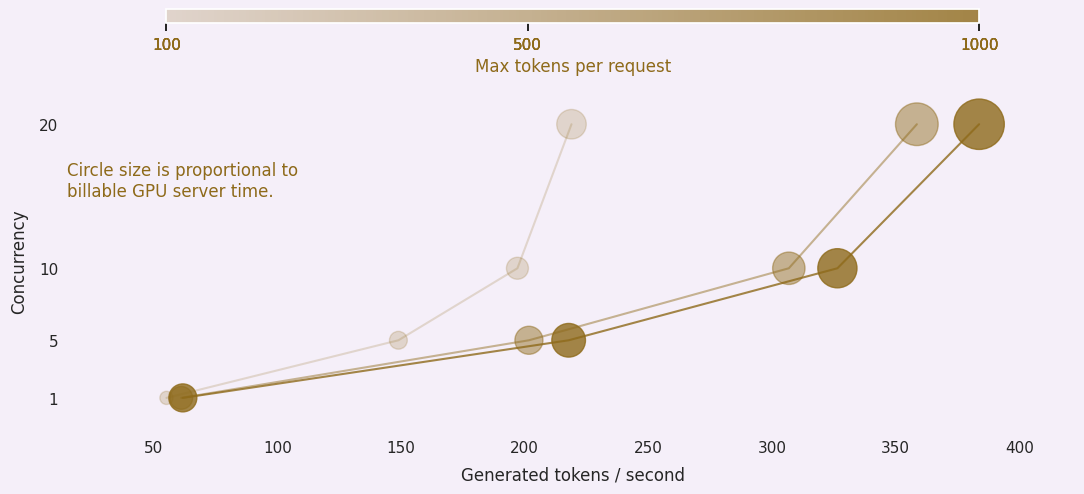

In [11]:
df['completion tokens / second'] = df.completion_tokens / df.total_time

fig, ax = plt.subplots(1,1,figsize=(11, 5))

alpha_bottom = .2
alpha_top = .8
max_token_alpha_map = create_mapping_function(
    df.max_tokens_per_request.min(), df.max_tokens_per_request.max(), 
    _max = alpha_top, _min = alpha_bottom
)
max_tokens_alphas = [max_token_alpha_map(v) for v in df.max_tokens_per_request]
request_map_for_colorbar = create_alpha_colormap(REQUEST_COLOR, alpha_bottom, alpha_top)

sm = plt.cm.ScalarMappable(cmap=request_map_for_colorbar, norm=plt.Normalize(vmin=alpha_bottom, vmax=alpha_top))
sm.set_array([])

for v in df.max_tokens_per_request.unique():
    _df = df[df.max_tokens_per_request==v]
    a = max_token_alpha_map(v)
    ax.scatter(
        _df['completion tokens / second'], _df['concurrent_requests'], 
        color = REQUEST_COLOR, 
        alpha = a,
        s = _df.total_time // 2,
    )
    spline = UnivariateSpline(_df['completion tokens / second'], _df['concurrent_requests'], s=1)
    _y = spline(_df['completion tokens / second'])
    ax.plot(
        _df['completion tokens / second'],
        _y, 
        alpha = a, 
        color = REQUEST_COLOR,
    )

request_ticks = df.concurrent_requests.unique()
divider = make_axes_locatable(ax)
x_start = df['completion tokens / second'].min()
x_dist = df['completion tokens / second'].max() - df['completion tokens / second'].min()
factor = request_ticks.max() * .35
y_start = request_ticks.max() + factor
y_dist = factor // 7
cax = ax.inset_axes([x_start, y_start, x_dist, y_dist], transform=ax.transData)
cbar = fig.colorbar(sm, orientation='horizontal', cax=cax)
cbar.set_ticks(max_tokens_alphas)
cbar.set_ticklabels([str(int(max_tpr)) for max_tpr in df.max_tokens_per_request], color=REQUEST_COLOR)
cbar.set_label('Max tokens per request', color=REQUEST_COLOR)

specific_concurrency_ticks = df.concurrent_requests.unique()
specific_concurrency_tick_labels = [str(int(tick)) for tick in specific_concurrency_ticks]
ax.set_yticks(specific_concurrency_ticks)
ax.set_yticklabels(specific_concurrency_tick_labels)
ax.set_ylabel('Concurrency', labelpad=LABELPAD)
ax.set_xlabel('Generated tokens / second', labelpad=LABELPAD)

_10pct = df['completion tokens / second'].max() * .1
x_min =  df['completion tokens / second'].min() - _10pct
x_max = df['completion tokens / second'].max() + _10pct
ax.set_xlim([x_min, x_max])
_10pct = df.concurrent_requests.max() * .1
y_min =  df.concurrent_requests.min() - _10pct
y_max = df.concurrent_requests.max() + _10pct
ax.set_ylim([y_min, y_max])

now = datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
formatted_device = device.lower().replace(' ', '_')

ax.text(15, 15, 'Circle size is proportional to \nbillable GPU server time.', color=REQUEST_COLOR)

plt.tight_layout(rect=[0, 0, 1, 1.05])

fig.savefig(f'concurrency_{formatted_device}_{now}.png')
fig.savefig(f'concurrency_{formatted_device}_{now}_transparent.png', transparent=True)

plt.show()

In [12]:
words_per_token = 0.75
words_in_a_page = 500
seconds_per_hour = 3600

print(f"(Estimated) number of document pages processed is {round(p_tokens * words_per_token * (1 / words_in_a_page))}.")
print(f"(Estimated) number of summary pages generated is {round(c_tokens * words_per_token * (1 / words_in_a_page))}.")
print(f"Billable compute time is {round(df.total_time.sum() / 3600, 3)} {device} hours.")

(Estimated) number of document pages processed is 51502.

(Estimated) number of summary pages generated is 5103.

Billable compute time is 3.464 NVIDIA A100-PCIE-40GB hours.

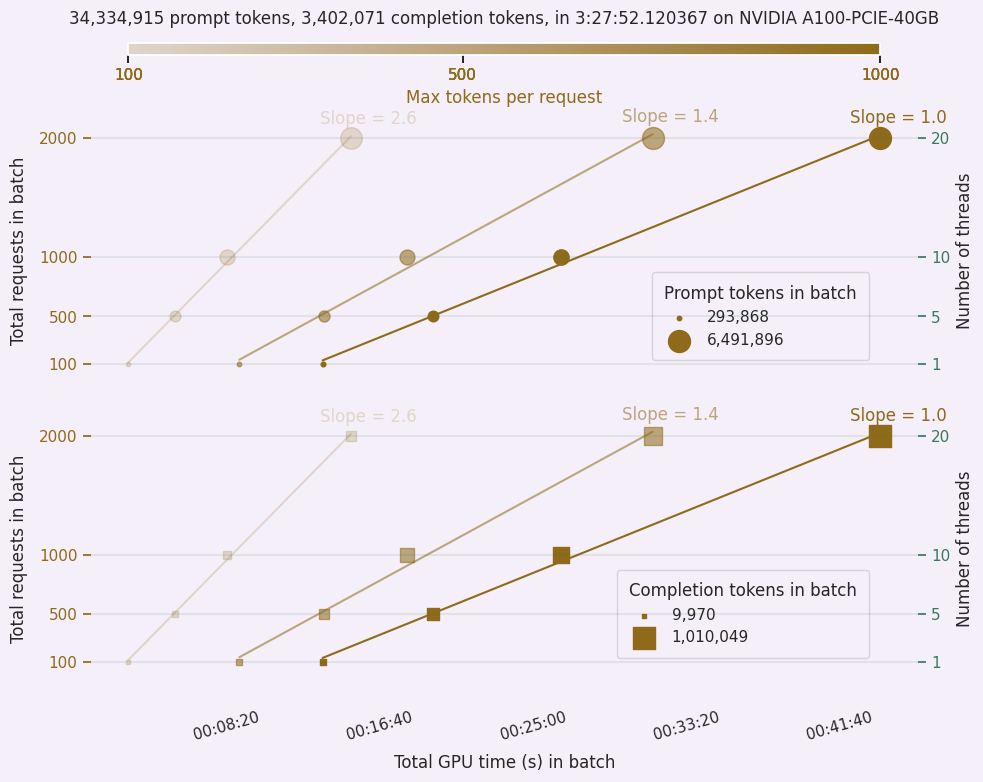

In [13]:
fig, ax = plt.subplot_mosaic(mosaic=[
    [ 'time and tokens - prompt' ],
    [ 'time and tokens - completion'] 
], figsize=(10,8))

alpha_bottom = .2
alpha_top = 1.
max_token_alpha_map = create_mapping_function(
    df.max_tokens_per_request.min(), df.max_tokens_per_request.max(), 
    _max = alpha_top, _min = alpha_bottom
)
max_tokens_alphas = [max_token_alpha_map(v) for v in df.max_tokens_per_request]
request_map_for_colorbar = create_alpha_colormap(REQUEST_COLOR, alpha_bottom, alpha_top)
sm = plt.cm.ScalarMappable(cmap=request_map_for_colorbar, norm=plt.Normalize(vmin=alpha_bottom, vmax=alpha_top))
sm.set_array([])

max_prompt_tokens = df.prompt_tokens.max()
min_prompt_tokens = df.prompt_tokens.min()
prompt_map = create_mapping_function(a=min_prompt_tokens, b=max_prompt_tokens)
prompt_tokens_size_scaling = [prompt_map(p_tokens) for p_tokens in df.prompt_tokens]
prompt_tokens_size_scaling_labels = [
    f"{p:,}"
    for p in [min_prompt_tokens, max_prompt_tokens]
]

max_completion_tokens = df.completion_tokens.max()
min_completion_tokens = df.completion_tokens.min()
completions_map = create_mapping_function(a=min_completion_tokens, b=max_completion_tokens)
completion_tokens_size_scaling = [completions_map(c_tokens) for c_tokens in df.completion_tokens]
completion_tokens_size_scaling_labels = [
    f"{c:,}"
    for c in [min_completion_tokens, max_completion_tokens]
]

request_ticks = df.total_requests.unique()
specific_request_tick_labels = [str(int(tick)) for tick in request_ticks]
specific_concurrency_ticks = df.concurrent_requests.unique()
specific_concurrency_tick_labels = [str(int(tick)) for tick in specific_concurrency_ticks]

def color_ax(handle='time and tokens - prompt', is_prompt=True, is_bottom=False):

    # Cbar only if bottom
    if is_bottom:
        ax[handle].set_xlabel(f'Total GPU time (s) in batch', labelpad=LABELPAD)
        ax[handle].tick_params(axis='x', rotation=16,  size=14)
        ax[handle].xaxis.set_major_formatter(FuncFormatter(lambda x, _: format_func(x, _)))
    else:
        ax[handle].set_title(title, y=1.3)
        ax[handle].set_xticks([])
        divider = make_axes_locatable(ax[handle])
        x_start = df.total_time.min()
        x_dist = df.total_time.max() - df.total_time.min()
        factor = request_ticks.max() * .35
        y_start = request_ticks.max() + factor
        y_dist = factor // 7
    
        cax = ax[handle].inset_axes([x_start, y_start, x_dist, y_dist], transform=ax[handle].transData)
        cbar = fig.colorbar(sm, orientation='horizontal', cax=cax)
        cbar.set_ticks(max_tokens_alphas)
        cbar.set_ticklabels([str(int(max_tpr)) for max_tpr in df.max_tokens_per_request], color=REQUEST_COLOR)
        cbar.set_label('Max tokens per request', color=REQUEST_COLOR)
        
    # ax.tick_params(axis='x', rotation=70)

    # ax[handle].yaxis.label.set_color(REQUEST_COLOR)
    ax[handle].tick_params(axis='y', colors=REQUEST_COLOR)
    ax[handle].set_ylabel('Total requests in batch', labelpad=LABELPAD)
    ax[handle].set_yticks(request_ticks)
    ax[handle].set_yticklabels(specific_request_tick_labels)

    ax_time_tokens_twin = ax[handle].twinx()
    ax_time_tokens_twin.set_ylabel('Number of threads')
    # ax_time_tokens_twin.yaxis.label.set_color(CONCURRENCY_COLOR)
    ax_time_tokens_twin.tick_params(axis='y', colors=CONCURRENCY_COLOR)
    ax_time_tokens_twin.set_yticks(specific_concurrency_ticks)
    ax_time_tokens_twin.set_yticklabels(specific_concurrency_tick_labels, color=CONCURRENCY_COLOR)

    if is_prompt:
        for t, r, a, s in zip(
            df.total_time, df.total_requests, max_tokens_alphas, prompt_tokens_size_scaling
        ):
            ax[handle].scatter(
                t, 
                r, 
                marker='o',
                color = REQUEST_COLOR, 
                s = s,
                alpha = a
            )
    else:
        for t, r, a, s in zip(
            df.total_time, df.total_requests, max_tokens_alphas, completion_tokens_size_scaling
        ):
            ax[handle].scatter(
                t, 
                r, 
                marker='s',
                color = REQUEST_COLOR, 
                s = s,
                alpha = a
            )
        
    
    for val in df.max_tokens_per_request.unique():
        _df = df[df.max_tokens_per_request == val]
        a = max_token_alpha_map(val)
        slope, intercept = np.polyfit(_df.total_time, _df.total_requests, deg=1)
        _y = _df.total_time * slope + intercept
        ax[handle].plot(
            _df.total_time, 
            _y, 
            alpha = a, 
            color = REQUEST_COLOR,
        )
        x_pos = _df.total_time.values[-1]
        x_pos -= 0.05 * request_ticks.max()
        y_pos = _y.values[-1]
        y_pos *= 1.05
        ax[handle].text(x_pos, y_pos, f"Slope = {round(slope, 1)}", fontsize=12, color=REQUEST_COLOR, alpha=a)

    if is_prompt:
        handles = [
            ax[handle].scatter([], [], s=prompt_map(min_prompt_tokens), color=REQUEST_COLOR, marker='o'),
            ax[handle].scatter([], [], s=prompt_map(max_prompt_tokens), color=REQUEST_COLOR, marker='o')
        ]
        leg = ax[handle].legend(
            handles, 
            prompt_tokens_size_scaling_labels, 
            title="Prompt tokens in batch",
            bbox_to_anchor=(.95, 0.45),
            borderpad=0.8
        )
    else:
        handles = [
            ax[handle].scatter([], [], s=completions_map(min_completion_tokens), color=REQUEST_COLOR, marker='s'),
            ax[handle].scatter([], [], s=completions_map(max_completion_tokens), color=REQUEST_COLOR, marker='s')
        ]
        leg = ax[handle].legend(
            handles, 
            completion_tokens_size_scaling_labels, 
            title="Completion tokens in batch",
            bbox_to_anchor=(.95, 0.45),
            borderpad=0.8
        )
    
    leg._legend_box.align = "left"
    
    _10pct = request_ticks.max() * .1
    ax[handle].set_ylim([request_ticks.min() - _10pct, request_ticks.max() + _10pct])
    
    for val in specific_concurrency_ticks:
        ax_time_tokens_twin.axhline(y=val, alpha=0.1, color=CONCURRENCY_COLOR)
    
    _10pct = specific_concurrency_ticks.max() * .1
    ax_time_tokens_twin.set_ylim(
        [specific_concurrency_ticks.min() - _10pct, specific_concurrency_ticks.max() + _10pct]
    )

color_ax(handle='time and tokens - prompt', is_prompt=True, is_bottom=False)
color_ax(handle='time and tokens - completion', is_prompt=False, is_bottom=True)

plt.tight_layout(rect=[0, 0, 1, 1])

now = datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
formatted_device = device.lower().replace(' ', '_')
fig.savefig(f'results_{formatted_device}_{now}.png')
fig.savefig(f'results_{formatted_device}_{now}_transparent.png', transparent=True)

plt.show()

### Promotheus

In [14]:
PROMETHEUS_URL = 'http://localhost:9090/'
START_TIME = datetime.utcnow() - timedelta(hours=20, minutes=0) 
END_TIME = datetime.utcnow() - timedelta(hours=16, minutes=25)
STEP = '15s'

QUERIES = [
    'num_requests_running',
    'gpu_cache_usage_perc',
    'num_requests_waiting',
    'generation_tokens_total',
    'prompt_tokens_total',
    'request_prompt_tokens_sum',
    'time_to_first_token_seconds_sum',
]

def to_unix_timestamp(dt):
    return int(dt.timestamp())

In [15]:
def prometheus_to_dataframe(result, metric_name):
    if 'data' in result and 'result' in result['data']:
        records = []
        for metric in result['data']['result']:
            metric_labels = metric['metric']
            for value in metric['values']:
                timestamp = datetime.fromtimestamp(value[0])
                value = float(value[1])
                record = {'timestamp': timestamp, 'value': value, 'metric': metric_name}
                record.update(metric_labels)
                records.append(record)
        return pd.DataFrame(records)
    else:
        print(f"No data found for query: {metric_name}")
        raise ValueError('Could not make pandas df from prometheus metrics.')
        # return pd.DataFrame()

In [16]:
def query_prometheus(query, start_time=None, end_time=None, step=None):
    url = f"{PROMETHEUS_URL}/api/v1/query"
    params = {'query': query}

    if start_time and end_time and step:
        url = f"{PROMETHEUS_URL}/api/v1/query_range"
        params.update({
            'start': to_unix_timestamp(start_time),
            'end': to_unix_timestamp(end_time),
            'step': step
        })
        
    response = requests.get(url, params=params)

    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(f"Query failed with status code {response.status_code}: {response.text}")

In [17]:
# requires running grafana and prometheus

all_dataframes = []
for query in QUERIES:
    result = query_prometheus(query, start_time=START_TIME, end_time=END_TIME, step=STEP)
    _df = prometheus_to_dataframe(result, query)
    all_dataframes.append(_df)
combined_df = pd.concat(all_dataframes, ignore_index=True)

In [18]:
nv_smi_out = pd.read_csv(
    '%s/%s_gpu_util.csv' % (OUTDATA_DIR, formatted_device)
)
nv_smi_out.Timestamp = nv_smi_out.Timestamp.apply(lambda x: datetime.fromtimestamp(x))
nv_smi_out.rename(columns={'Timestamp': 'timestamp'}, inplace=True)
gpu_util = nv_smi_out.rename(columns={'GPU Utilization (%)': 'value'}).drop(columns=['GPU Memory Utilization (%)'])
gpu_util['metric'] = ['GPU core utilization (%)'] * gpu_util.shape[0]
mem_util = nv_smi_out.rename(columns={'GPU Memory Utilization (%)': 'value'}).drop(columns=['GPU Utilization (%)'])
mem_util['metric'] = ['GPU memory utilization (%)'] * mem_util.shape[0]

In [19]:
combined_df = pd.concat([combined_df, gpu_util, mem_util])
combined_df

,timestamp,value,metric,__name__,instance,job,model_name
0,2024-06-08 19:47:03,1.0,num_requests_running,num_requests_running,localhost:8000,prometheus,/tmp/meta--llama3-8b-instruct-p_cmc43l
1,2024-06-08 19:47:18,0.0,num_requests_running,num_requests_running,localhost:8000,prometheus,/tmp/meta--llama3-8b-instruct-p_cmc43l
2,2024-06-08 19:47:33,1.0,num_requests_running,num_requests_running,localhost:8000,prometheus,/tmp/meta--llama3-8b-instruct-p_cmc43l
3,2024-06-08 19:47:48,1.0,num_requests_running,num_requests_running,localhost:8000,prometheus,/tmp/meta--llama3-8b-instruct-p_cmc43l
4,2024-06-08 19:48:03,1.0,num_requests_running,num_requests_running,localhost:8000,prometheus,/tmp/meta--llama3-8b-instruct-p_cmc43l
...,...,...,...,...,...,...,...
11714,2024-06-08 23:09:46,81.0,GPU memory utilization (%),NaN,NaN,NaN,NaN
11715,2024-06-08 23:09:47,82.0,GPU memory utilization (%),NaN,NaN,NaN,NaN
11716,2024-06-08 23:09:48,83.0,GPU memory utilization (%),NaN,NaN,NaN,NaN
11717,2024-06-08 23:09:49,84.0,GPU memory utilization (%),NaN,NaN,NaN,NaN


In [20]:
prompt_tokens = combined_df[combined_df.metric == 'prompt_tokens_total']
prompt_tokens['diff'] = prompt_tokens.value.diff()

gen_tokens = combined_df[combined_df.metric == 'generation_tokens_total']
gen_tokens['diff'] = gen_tokens.value.diff()

In [21]:
def f(row):
    if row.metric == 'gpu_cache_usage_perc':
        return 100 * row.value
    else:
        return row.value

combined_df['value'] = combined_df.apply(f, axis=1)
# combined_df[combined_df.metric=='gpu_cache_usage_perc']

In [22]:
combined_df

,timestamp,value,metric,__name__,instance,job,model_name
0,2024-06-08 19:47:03,1.0,num_requests_running,num_requests_running,localhost:8000,prometheus,/tmp/meta--llama3-8b-instruct-p_cmc43l
1,2024-06-08 19:47:18,0.0,num_requests_running,num_requests_running,localhost:8000,prometheus,/tmp/meta--llama3-8b-instruct-p_cmc43l
2,2024-06-08 19:47:33,1.0,num_requests_running,num_requests_running,localhost:8000,prometheus,/tmp/meta--llama3-8b-instruct-p_cmc43l
3,2024-06-08 19:47:48,1.0,num_requests_running,num_requests_running,localhost:8000,prometheus,/tmp/meta--llama3-8b-instruct-p_cmc43l
4,2024-06-08 19:48:03,1.0,num_requests_running,num_requests_running,localhost:8000,prometheus,/tmp/meta--llama3-8b-instruct-p_cmc43l
...,...,...,...,...,...,...,...
11714,2024-06-08 23:09:46,81.0,GPU memory utilization (%),NaN,NaN,NaN,NaN
11715,2024-06-08 23:09:47,82.0,GPU memory utilization (%),NaN,NaN,NaN,NaN
11716,2024-06-08 23:09:48,83.0,GPU memory utilization (%),NaN,NaN,NaN,NaN
11717,2024-06-08 23:09:49,84.0,GPU memory utilization (%),NaN,NaN,NaN,NaN


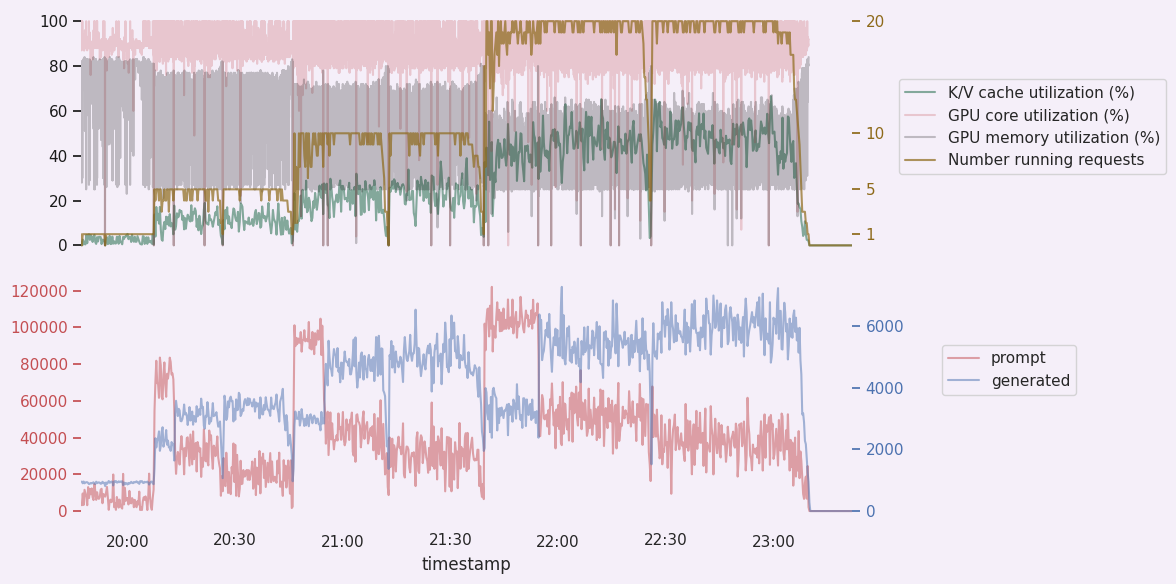

In [23]:
fig, ax = plt.subplots(2, 1, figsize=(12,6), sharex=True)

def overlay_metric(full_df, ax, metric_type, label, a, c):
    metric_df = full_df[full_df.metric==metric_type]
    h = metric_df.plot(x='timestamp', y='value', label=label, ax=ax, alpha=a, color=c)
    ax.tick_params(axis='y', colors=c) 
    return h

ax[0].set_ylim([-5, 105])
h=overlay_metric(combined_df, ax[0], metric_type='gpu_cache_usage_perc', label='K/V cache utilization (%)', a=0.6, c=CONCURRENCY_COLOR)
kv_cache_util = [label.get_text() for label in ax[0].get_yticklabels()]
kv_cache_util = [tick for tick in kv_cache_util if tick]  # Filter out empty strings
kv_cache_util = [float(tick.replace('−', '-')) if '−' in tick else float(tick) for tick in kv_cache_util]

# ax.set_yticklabels(kv_cache_util)
overlay_metric(gpu_util, ax[0], metric_type='GPU core utilization (%)', label='GPU core utilization (%)', a=0.25, c='r')
overlay_metric(mem_util, ax[0], metric_type='GPU memory utilization (%)', label='GPU memory utilization (%)', a=0.25, c='k')

twin_ax=ax[0].twinx()
h=overlay_metric(combined_df, twin_ax, metric_type='num_requests_running', label='Number running requests', a=0.7, c=REQUEST_COLOR)
specific_concurrency_ticks = df.concurrent_requests.unique()
specific_concurrency_tick_labels = [str(tick) for tick in specific_concurrency_ticks]
twin_ax.set_yticks(specific_concurrency_ticks)
twin_ax.set_yticklabels(specific_concurrency_tick_labels, color=REQUEST_COLOR)
twin_ax.set_ylim([-1, 21])

handles, labels = ax[0].get_legend_handles_labels()
handles2, labels2 = twin_ax.get_legend_handles_labels()
ax[0].legend(handles + handles2, labels + labels2, bbox_to_anchor=[1.05, .75, 0., 0.])
twin_ax.get_legend().remove()

prompt_tokens.plot(x='timestamp', y='diff', ax=ax[1], label='prompt', color='r', alpha=.5)
ax[1].tick_params(axis='y', colors='r')
twin_ax2 = ax[1].twinx()
gen_tokens.plot(x='timestamp', y='diff', ax=twin_ax2, label='generated', color='b', alpha=.5)
twin_ax2.tick_params(axis='y', colors='b')

handles, labels = ax[1].get_legend_handles_labels()
handles2, labels2 = twin_ax2.get_legend_handles_labels()
ax[1].legend(handles + handles2, labels + labels2, bbox_to_anchor=[1.3, .75, 0., 0.])
twin_ax2.get_legend().remove()

plt.tight_layout(rect=[0., 0., 1., 1.])

fig.savefig(f'util_{formatted_device}_{now}.png')
fig.savefig(f'util_{formatted_device}_{now}_transparent.png', transparent=True);